In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file to explore its content and structure
campaign_data = pd.read_csv('Amazon Ads All.csv')

# Display the first few rows of the dataframe and the column names to understand the dataset
campaign_data.head(), campaign_data.columns

(   ADV_ID    AD_ID         SKU     placement_slot  impressions  clicks  \
 0   84373  6370624  9985955750  offsite_mobileweb         1089       0   
 1   84373  1295011  7875390725    offsite_desktop         2043       0   
 2   84373  6370624  9985955750  offsite_mobileweb         1452       0   
 3   84373  1295011  7875390725    offsite_desktop         1312       0   
 4   84373  1295011  7875390725  offsite_mobileapp            8       0   
 
    auction_cost  adjusted_cost hit_day_utc  \
 0      10.89000        8.79000    02/05/24   
 1      26.61464       19.44791    01/05/24   
 2      14.52000       11.68400    01/05/24   
 3      16.59940       11.94286    30/04/24   
 4       0.11608        0.07161    01/05/24   
 
                                  targeting_secondary    vertical  \
 0       category=Automotive Replacement Control Arms  Automotive   
 1         category=Automotive Replacement Brake Kits  Automotive   
 2       category=Automotive Replacement Control Arms  Au

In [7]:
# Attempt to parse dates in the '%d/%m/%y' format
campaign_data['hit_day_utc_parsed'] = pd.to_datetime(campaign_data['hit_day_utc'], format='%d/%m/%y', errors='coerce')

# Parse remaining unparsed dates in the '%Y-%m-%d %H:%M:%S' format
mask = campaign_data['hit_day_utc_parsed'].isna()
campaign_data.loc[mask, 'hit_day_utc_parsed'] = pd.to_datetime(campaign_data.loc[mask, 'hit_day_utc'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Check for any remaining non-parsed dates
remaining_non_parsed = campaign_data[campaign_data['hit_day_utc_parsed'].isna()]
if not remaining_non_parsed.empty:
    print("Remaining non-parsed dates:")
    print(remaining_non_parsed)

# Print unique months in the parsed 'hit_day_utc_parsed' column
print("Unique months in 'hit_day_utc_parsed':")
print(campaign_data['hit_day_utc_parsed'].dt.month.unique())

# Extract month and day of the week from parsed dates
campaign_data['month'] = campaign_data['hit_day_utc_parsed'].dt.month
campaign_data['day_of_week'] = campaign_data['hit_day_utc_parsed'].dt.dayofweek

# Convert 'day_of_week' from numerical to categorical for better understanding
day_of_week_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
campaign_data['day_of_week_name'] = campaign_data['day_of_week'].map(day_of_week_dict)
print(campaign_data['hit_day_utc_parsed'].dt.month.unique())




Unique months in 'hit_day_utc_parsed':
[5 4 3 2]


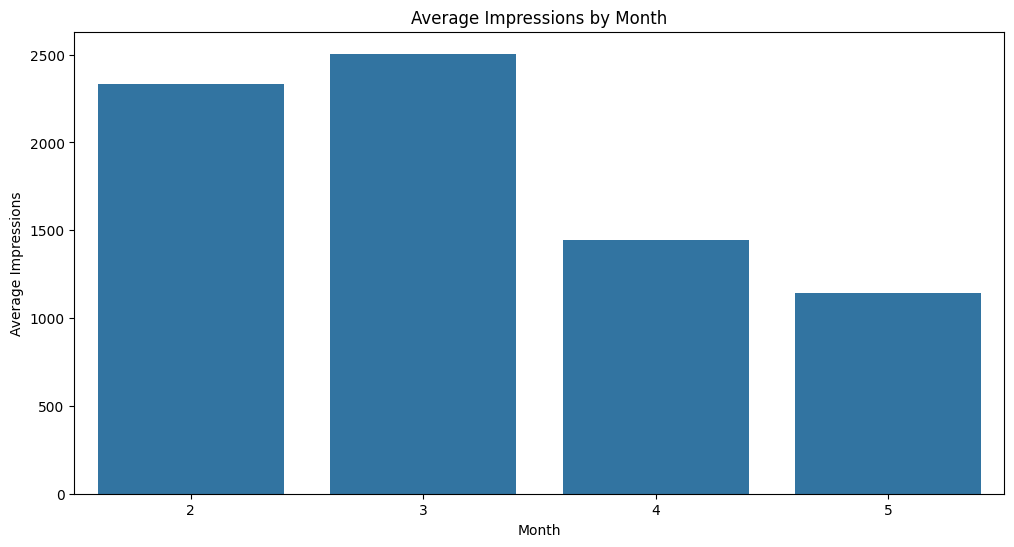

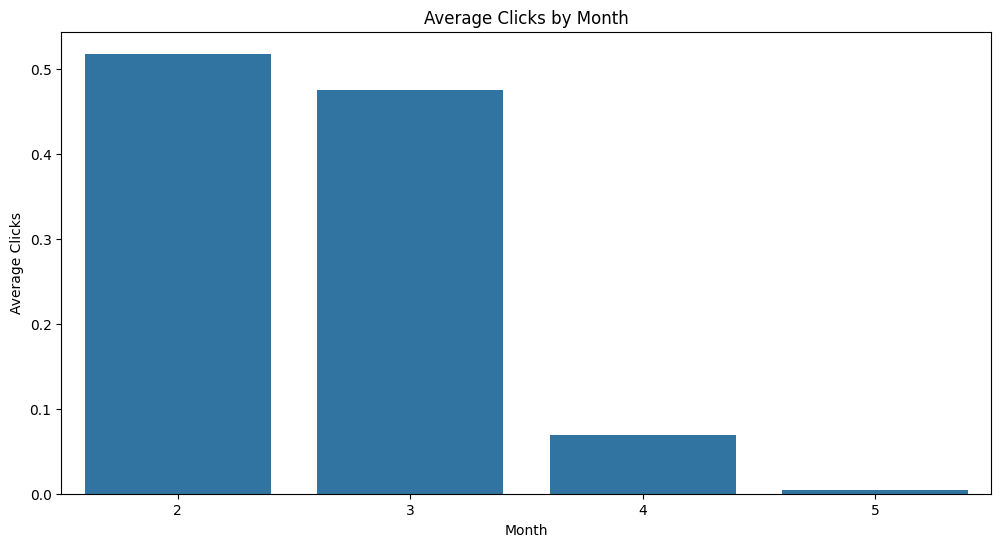

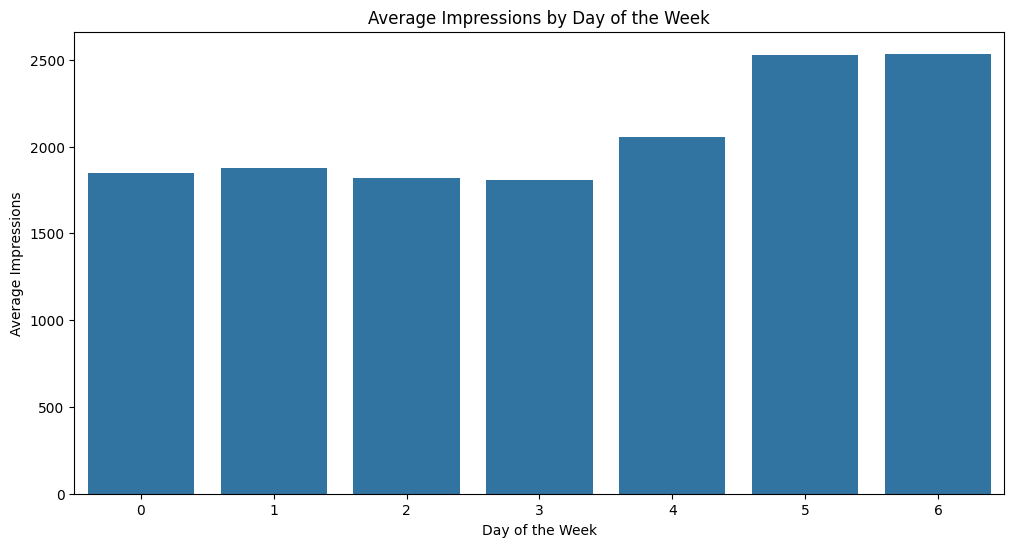

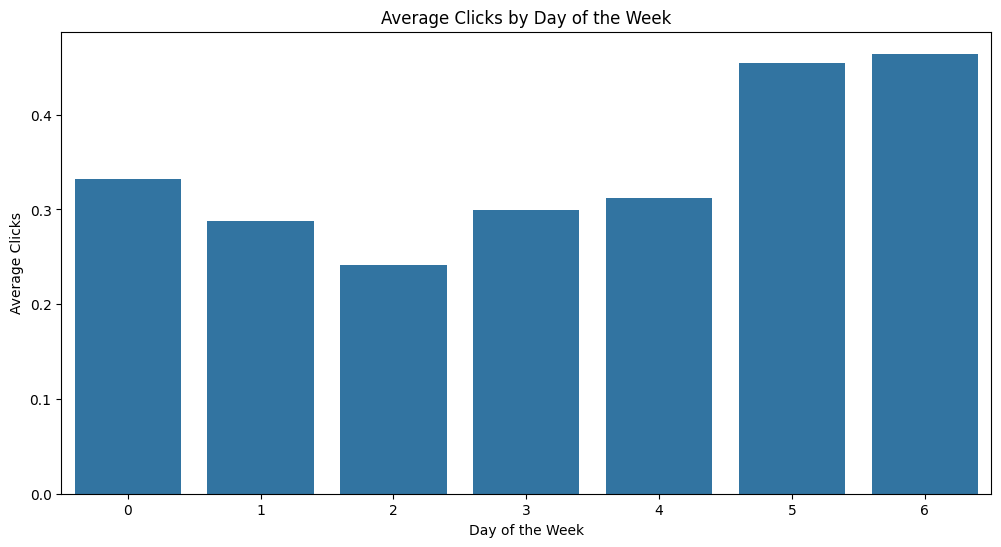

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean impressions and clicks for each month
mean_impressions_by_month = campaign_data.groupby('month')['impressions'].mean()
mean_clicks_by_month = campaign_data.groupby('month')['clicks'].mean()

# Calculate the mean impressions and clicks for each day of the week
mean_impressions_by_day = campaign_data.groupby('day_of_week')['impressions'].mean()
mean_clicks_by_day = campaign_data.groupby('day_of_week')['clicks'].mean()

# Plot the mean impressions for each month
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_impressions_by_month.index, y=mean_impressions_by_month.values)
plt.title('Average Impressions by Month')
plt.xlabel('Month')
plt.ylabel('Average Impressions')
plt.show()

# Plot the mean clicks for each month
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_clicks_by_month.index, y=mean_clicks_by_month.values)
plt.title('Average Clicks by Month')
plt.xlabel('Month')
plt.ylabel('Average Clicks')
plt.show()

# Plot the mean impressions for each day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_impressions_by_day.index, y=mean_impressions_by_day.values)
plt.title('Average Impressions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Impressions')
plt.show()

# Plot the mean clicks for each day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_clicks_by_day.index, y=mean_clicks_by_day.values)
plt.title('Average Clicks by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Clicks')
plt.show()


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features and target variables
features = ['month', 'day_of_week']
target_impressions = 'impressions'
target_clicks = 'clicks'

# Prepare the data
X = campaign_data[features]
y_impressions = campaign_data[target_impressions]
y_clicks = campaign_data[target_clicks]

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), features)
    ])

# Define and train the model for impressions
model_impressions = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model_impressions.fit(X, y_impressions)

# Define and train the model for clicks
model_clicks = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model_clicks.fit(X, y_clicks)

# Print coefficients to understand the impact of each month and day
coefficients_impressions = model_impressions.named_steps['regressor'].coef_
coefficients_clicks = model_clicks.named_steps['regressor'].coef_
print("Impressions Model Coefficients:", coefficients_impressions)
print("Clicks Model Coefficients:", coefficients_clicks)


Impressions Model Coefficients: [ 443.71273428  581.42391422 -444.86170451 -580.27494399 -179.39764559
 -126.60776385 -158.74153989 -291.71304848  -70.96845551  404.2796557
  423.14879763]
Clicks Model Coefficients: [ 0.2370421   0.18766214 -0.21328454 -0.2114197   0.0078674  -0.02575239
 -0.06867995 -0.06165655 -0.05196779  0.09365853  0.10653075]


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features and target variables
features = ['month', 'day_of_week']
target_impressions = 'impressions'
target_clicks = 'clicks'

# Prepare the data
X = campaign_data[features]
y_impressions = campaign_data[target_impressions]
y_clicks = campaign_data[target_clicks]

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), features)
    ])

# Define and train the model for impressions
model_impressions = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model_impressions.fit(X, y_impressions)

# Define and train the model for clicks
model_clicks = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model_clicks.fit(X, y_clicks)

# Print coefficients to understand the impact of each month and day
feature_names = model_impressions.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(features)
coefficients_impressions = model_impressions.named_steps['regressor'].coef_
coefficients_clicks = model_clicks.named_steps['regressor'].coef_

# Combine feature names and coefficients into a readable format
import pandas as pd

coef_impressions_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_impressions
})
coef_clicks_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_clicks
})

print("Impressions Model Coefficients:")
print(coef_impressions_df)

print("\nClicks Model Coefficients:")
print(coef_clicks_df)


Impressions Model Coefficients:
          Feature  Coefficient
0         month_2   443.712734
1         month_3   581.423914
2         month_4  -444.861705
3         month_5  -580.274944
4   day_of_week_0  -179.397646
5   day_of_week_1  -126.607764
6   day_of_week_2  -158.741540
7   day_of_week_3  -291.713048
8   day_of_week_4   -70.968456
9   day_of_week_5   404.279656
10  day_of_week_6   423.148798

Clicks Model Coefficients:
          Feature  Coefficient
0         month_2     0.237042
1         month_3     0.187662
2         month_4    -0.213285
3         month_5    -0.211420
4   day_of_week_0     0.007867
5   day_of_week_1    -0.025752
6   day_of_week_2    -0.068680
7   day_of_week_3    -0.061657
8   day_of_week_4    -0.051968
9   day_of_week_5     0.093659
10  day_of_week_6     0.106531
